
# ImPorting and cleaning

In [1]:
import matplotlib
%matplotlib inline
%config InlineBAckend.figure.format = 'svg'
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import pandas as pd
import numpy as np


from tqdm import tqdm 

from sklearn.cluster import KMeans , DBSCAN
from sklearn.metrics import silhouette_score
from sklearn.datasets import make_blobs
from sklearn.neighbors import KNeighborsClassifier

from ipywidgets import interactive

from collections import defaultdict
import hdbscan
import folium
import re

cols = ['#e6194b', '#3cb44b', '#ffe119', '#4363d8', '#f58231', '#911eb4',
        '#46f0f0', '#f032e6', '#bcf60c', '#fabebe', '#008080', '#e6beff', 
        '#9a6324', '#fffac8', '#800000', '#aaffc3', '#808000', '#ffd8b1', 
        '#000075', '#808080']*10

In [2]:

df = pd.read_csv('Data/taxi_data.csv')

In [3]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [4]:
# Are there any duplicate values
df.duplicated(subset =['LON' , 'LAT']).values.any()
#a =pd.DataFrame([1,1])
#a.duplicated()

True

In [5]:
df.isna().values.any()

True

In [6]:
print('Before dropping duplicates amd NAN , shape :' , df.shape)
df.dropna(inplace = True)
df.drop_duplicates(subset=['LON' ,'LAT'] , inplace = True)
#By default keep has the value 'first'
#c = df.drop_duplicates(subset=['LON' ,'LAT'] , keep ='first')
print('After dropping duplicates amd NAN , shape :' , df.shape)

Before dropping duplicates amd NAN , shape : (838, 3)
After dropping duplicates amd NAN , shape : (823, 3)


In [7]:
df.head()

LON       LAT                          NAME
0  28.17858 -25.73882         11th Street Taxi Rank
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank
2  27.83239 -26.53722          Adams Road Taxi Rank
3  28.12514 -26.26666  Alberton City Mall Taxi Rank
4  28.10144 -26.10567      Alexandra Main Taxi Rank

In [8]:
X = df[['LON' ,'LAT' ]]
X.dtype = 'base64'

In [9]:
X.LON.mean()


28.06590763061967

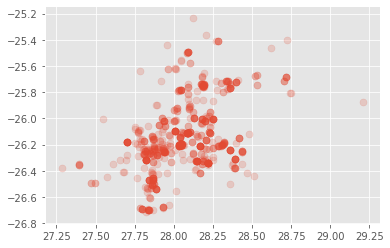

In [10]:
# alpha = level of transparence
# s= size
plt.scatter(X['LON'] , X['LAT'] , alpha = 0.2 , s= 50)

# Visualisation Graphically



In [11]:
m = folium.Map(location = [X['LAT'].mean() , X['LON'].mean()] , 
               tiles = 'Stamen Toner',
              zoom_start = 9,
              )

for _ , row in df.iterrows():
    folium.CircleMarker(
            location = [row.LAT , row.LON],
            radius = 5,
            popup = row.NAME,
            color = '#1787FE',
            #fill = True,
            #fill_colour = '#1787FE'
            
    
    ).add_to(m)
    
    

In [12]:
m


# # # CLustering


In [13]:
 X_blobs, _ = make_blobs(n_samples = 1000 , centers =10 , n_features = 2 ,
                          cluster_std = 0.5 , random_state = 4)

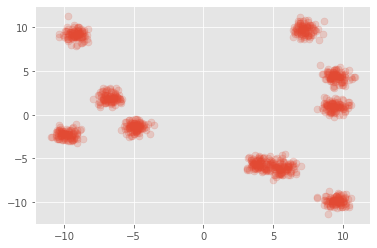

In [14]:
plt.scatter(X_blobs[: , 0] , X_blobs[: , 1] , alpha = 0.2 , s= 50)

In [15]:
class_prediction = np.load('Data/sample_clusters.npy')

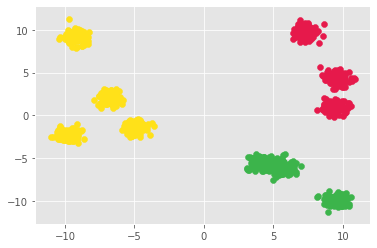

In [16]:
unique_clusters = np.unique( class_prediction )

for unique_cluster in unique_clusters:
    x = X_blobs[class_prediction == unique_cluster]
    plt.scatter(x[: ,0] , x[ : , 1] , c = cols[unique_cluster])
    

In [17]:
silhouette_score(X_blobs , class_prediction)

0.6657220862867241

# KMeans


In [18]:
X = np.array(df[['LON' ,'LAT']] , dtype= 'float64')
k = 70 
model = KMeans(n_clusters = k , random_state =17).fit(X)
class_predictions = model.predict(X)
df[f'CLUSTER_kmeans{k}'] = class_predictions

In [19]:
df.head()

LON       LAT                          NAME  CLUSTER_kmeans70
0  28.17858 -25.73882         11th Street Taxi Rank                15
1  28.17660 -25.73795    81 Bazaar Street Taxi Rank                15
2  27.83239 -26.53722          Adams Road Taxi Rank                 5
3  28.12514 -26.26666  Alberton City Mall Taxi Rank                33
4  28.10144 -26.10567      Alexandra Main Taxi Rank                18

In [20]:
def create_map(df , cluster_column):
    m = folium.Map(location = [df['LAT'].mean() , df['LON'].mean()] , 
                   tiles = 'Stamen Toner',
                  zoom_start = 9
                  )

    for _ , row in df.iterrows():
        
        
        
        if row[cluster_column] == -1:
            cluster_colour = '#000000'
        else:
            cluster_colour = cols[row[cluster_column]]
        
        
        folium.CircleMarker(
                location = [row.LAT , row.LON],
                radius = 5,
                popup = row[cluster_column],
                color = cluster_colour,
                fill = True,
                fill_colour = cluster_colour


        ).add_to(m)
        
    return m  

    
    

In [21]:
m = create_map(df ,'CLUSTER_kmeans70' )
print(f'k ={k}')
print(f'solhouette_Score  : {silhouette_score(X , class_predictions)}')
      
m.save('kmeans_70.html')

k =70
solhouette_Score  : 0.6367300948961482


In [22]:
m

### DBSCAN


In [23]:
model = DBSCAN(eps = 0.01 , min_samples=5).fit(X)
class_predictions = model.labels_
  
df['CLUSTER_DBSCAN'] = class_predictions


In [24]:
m = create_map(df , 'CLUSTER_DBSCAN')
m.save('DBSCAN.html')
m

In [25]:
print('number of clusters found :',len(np.unique(class_predictions)))
print("number of outliers:" ,len(class_predictions[class_predictions==-1]) )
print('silhouette score ignoring outliers:' ,silhouette_score(X[class_predictions!=-1] ,class_predictions[class_predictions!=-1]))  


no_outliers =np.array([(counter + 2)*x if x == -1 else x for counter ,x in enumerate(class_predictions)])
print("silhoette score including outliers" , silhouette_score(X, no_outliers ) )

number of clusters found : 51
number of outliers: 289
silhouette score ignoring outliers: 0.9232138250288208
silhoette score including outliers 0.5667489350583482


## HDBSCAN


In [26]:
model = hdbscan.HDBSCAN(min_cluster_size=5 , min_samples= 2 , cluster_selection_epsilon=0.01)
class_predictions = model.fit_predict(X)

In [27]:

  
df['CLUSTER_HDBSCAN'] = class_predictions

m = create_map(df , 'CLUSTER_HDBSCAN')
m.save('HDBSCAN.html')
m

In [28]:
print('number of clusters found :',len(np.unique(class_predictions)))
print("number of outliers:" ,len(class_predictions[class_predictions==-1]) )
print('silhouette score ignoring outliers:' ,silhouette_score(X[class_predictions!=-1] ,class_predictions[class_predictions!=-1]))  


no_outliers =np.array([(counter + 2)*x if x == -1 else x for counter ,x in enumerate(class_predictions)])
print("silhoette score including outliers" , silhouette_score(X, no_outliers ) )

number of clusters found : 67
number of outliers: 102
silhouette score ignoring outliers: 0.7670504356844786
silhoette score including outliers 0.638992483305273


# Addressing Outliers


In [29]:
classifier = KNeighborsClassifier(n_neighbors=1)
df_train = df[df.CLUSTER_HDBSCAN !=-1]
df_predict = df[df.CLUSTER_HDBSCAN == - 1]


X_train = np.array(df_train[['LON', 'LAT']], dtype='float64')
y_train = np.array(df_train['CLUSTER_HDBSCAN'])

X_predict = np.array(df_predict[['LON', 'LAT']], dtype='float64')

In [30]:
classifier.fit(X_train , y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

In [31]:
predcitions = classifier.predict(X_predict)

In [32]:
df['CLUSTER_hybrid'] = df['CLUSTER_HDBSCAN']
df['CLUSTER_hybrid'][df.CLUSTER_hybrid == -1] = predcitions

/home/enigma/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [33]:
np.unique(df['CLUSTER_hybrid'].values)


array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
       34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
       51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65])

In [34]:
m = create_map(df , 'CLUSTER_hybrid')
m

In [35]:
class_predictions = df['CLUSTER_hybrid']

In [36]:
print(f'Number of clusters found: {len(np.unique(class_predictions))}')
print(f'Silhouette: {silhouette_score(X, class_predictions)}')

m.save('hybrid.html')

Number of clusters found: 66
Silhouette: 0.5849126494706486


Text(0.5, 1.0, 'Comparing Hybrid and K-Means Approaches')

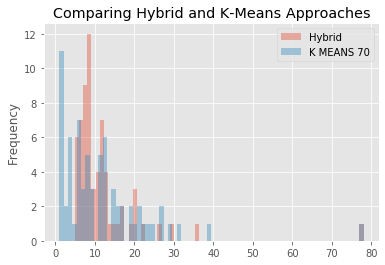

In [37]:
df['CLUSTER_hybrid'].value_counts().plot.hist(bins = 70 , alpha = 0.4,
                                              label = 'Hybrid')
df['CLUSTER_kmeans70'].value_counts().plot.hist(bins = 70 , alpha = 0.4,
                                              label = 'K MEANS 70')
plt.legend()
plt.title('Comparing Hybrid and K-Means Approaches')